<a target="_blank"
  href="https://colab.research.google.com/github/sk-classroom/aps-recurrent_neural_network/blob/main/assignment/assignment.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Assignment: 🛍️ Predicting Purchases with Recurrent Neural Networks (RNNs)  

![](https://cdn.prod.website-files.com/663e17fff238bd97b0a022cd/6645d94cef2950a240114cda_amazon-recommendations-category-page.jpeg)



## **Why Does This Matter?**  

Every time you browse an online store, the platform tracks your interactions—what you click, how long you view an item, and what you ultimately buy. These behavioral sequences contain rich patterns that companies use to predict future purchases, recommend products, and optimize sales strategies. But how do they do this?  

One powerful approach is using **Recurrent Neural Networks (RNNs)**, a class of neural networks specifically designed to process sequential data. Unlike traditional models that treat data points independently, RNNs maintain a memory of past interactions, making them well-suited for tasks like product recommendation, speech recognition, and time-series forecasting.  

In this assignment, you will build an RNN that predicts which product a user will purchase based on their viewing history. You will start with AI-generated code that has flaws—your job is to diagnose and fix these issues, ensuring the model reaches an acceptable accuracy level. This exercise will strengthen your ability to work with sequential data and debug deep learning models.  


## **Your Task**  

You will develop an RNN-based model that processes user viewing histories and predicts the product they will buy. The dataset consists of sequences of product views, with a label indicating the purchased product.  

- 📂 **Dataset**: Provided as `train_data.csv` and `test_data.csv` in the `./data` folder.  
- 🔢 **Product IDs**: 34 distinct products, labeled from `0` to `34`.  

### **What You Need to Do**  

1. **Understand the Problem**: You will work with sequential purchase data, applying RNNs to make predictions.  
2. **Fix the AI-Generated Code**: The provided RNN implementation is flawed. Carefully debug and improve it to meet performance requirements.  
3. **Optimize Your Model**: Tune hyperparameters (e.g., hidden size, number of layers, learning rate) while ensuring efficient training.  
4. **Train & Evaluate**: Train your model on `train_data.csv` and ensure it achieves at least **50% accuracy** on `test_data.csv`.  
5. **Submit Your Work**: Save your trained model and notebook as specified below.  


## **Model Requirements**  

✅ **Architecture**  
- Implement an **RNN** that processes sequential product-viewing data.  
- You may NOT use **LSTMs or GRUs** to enhance model performance.  
- Do not import additional libraries—the grading script will fail otherwise.  

✅ **Performance Goals**  
- Achieve at least **65% accuracy** when predicting purchases.  

✅ **Efficiency Constraints**  
- The model must run **within GitHub Actions** without timing out or exceeding memory limits.  
- Use batch processing and efficient tensor operations.  

✅ **Debugging & Improvement**  
- The provided RNN code **contains errors**. You must find and correct them.  
- Pay special attention to **activation functions, gradient clipping, loss computation, and data handling**.  

✅ **Submission Guidelines**  
- Save your trained model as `trained_model.pth` in `./assignment`.  
- Your notebook should be named **`assignment.ipynb`** and placed in `./assignment`.  
- Use `git add`, `git commit`, and `git push` to submit your work.  


## **Important Rules**  

🚫 **Don’ts:**  
- ❌ Do **not** import any additional libraries.  
- ❌ Do **not** modify function names—grading scripts rely on them.  
- ❌ Do **not** remove cells tagged `"gradable"`; they are required for grading.  

✅ **Do’s:**  
- ✔️ Use linters & formatters (e.g., `black`) for clean, readable code.  
- ✔️ Add comments and explanations to make your work understandable.  
- ✔️ If adding new code cells, tag them as `"gradable"` if they should be evaluated.  

In [ ]:
from typing import Tuple, Optional
from torch import Tensor, zeros, eye, int64, tanh, no_grad, save, load, max
from torch.nn import Module, Linear, ReLU, Embedding, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
import numpy as np
from pandas import read_csv

Let's load the training and testing CSV data. Each row captures a user’s product-viewing sequence and the final product they purchased. We will later transform these raw sequences into a form suitable for our model.

In [ ]:
train_data_table = read_csv("../data/train_data.csv")
test_data_table = read_csv("../data/test_data.csv")

Here, we define our custom dataset that uses one-hot embeddings and build the basic RNN structure. The dataset class handles transformation of product IDs into embeddings, and the custom RNN uses linear layers to process sequential data.

In [ ]:
class CustomDataset(Dataset):
    """Dataset for time series prediction.
    HINT: Think about what type of data PyTorch expects
    """
    def __init__(self, vocab_size: int, sequences: Tensor, target: Tensor):
        self.sequences = sequences
        self.target = target

        # One hot encoding
        self.embedding = Embedding(num_embeddings=vocab_size, embedding_dim=vocab_size)
        self.embedding.weight.data = eye(vocab_size)
        self.embedding.weight.requires_grad = False

    def __len__(self) -> int:
        return self.sequences.shape[0]

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        seq, target = self.sequences[idx, :], self.target[idx]

        # one hot encoding
        seq_one_hot = self.embedding(seq)

        return seq_one_hot, target


Each input sequence consists of a series of product IDs. Since neural networks operate on numerical vectors rather than categorical IDs, we use **one-hot encoding**:

$$
x_i \in \{0,1\}^{V}
$$

where $V$ is the vocabulary size (number of unique product IDs). For a given sequence $ S = (s_1, s_2, ..., s_T)$, each $s_t$ is transformed into a one-hot vector.

For instance, if $V = 34$ and a product ID is **5**, its one-hot encoding would be:

$$
[0,0,0,0,0,1,0,...,0] \quad \text{(34-dimensional vector)}
$$

The embedding layer in the dataset definition performs this transformation.

We split the dataset into training and validation sets. By specifying a ratio, we ensure part of the data is held out for validation to check our model’s performance during training.

In [ ]:
def prepare_data_splits(dataset: Dataset, train_ratio: float,
                       batch_size: int) -> Tuple[DataLoader, DataLoader]:
    """Split dataset into training and validation sets.
    """
    train_size = int(train_ratio * (len(dataset)))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader

In our RNN, the hidden state is updated at each time step using the recurrence relation:

$$
h_t = \tanh(W_x x_t + W_h h_{t-1} + b)
$$

where:

- $ x_t \in \mathbb{R}^{V} $ is the one-hot encoded product viewed at time $ t $,
- $ h_t \in \mathbb{R}^{H} $ is the hidden state at time $ t $,
- $ W_x \in \mathbb{R}^{H \times V} $ is the weight matrix for the input,
- $ W_h \in \mathbb{R}^{H \times H} $ is the recurrent weight matrix,
- $ b \in \mathbb{R}^{H} $ is the bias term,
- $ \tanh(\cdot) $ is a non-linear activation function.

The final output layer projects the hidden state into an output vector:

$
o = W_o h_T + b_o
$

where $ W_o \in \mathbb{R}^{V \times H} $ maps the hidden state to a probability distribution over product IDs.


In [ ]:
class CustomNeuralNetwork(Module):
    """Basic RNN for time series prediction.
    HINT: What makes neural networks non-linear?
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(CustomNeuralNetwork, self).__init__()
        self.input_size = input_size  # Store input size
        self.hidden_size = hidden_size
        self.output_size = output_size  # Store output size
        self.l1 = Linear(input_size, hidden_size)
        self.l2 = Linear(hidden_size, hidden_size)
        self.l3 = Linear(hidden_size, output_size)

    def forward(self, x: Tensor, h_0: Optional[Tensor] = None) -> Tensor:
        """ Forward pass of the RNN."""
        batch_size, seq_length, n_features = x.size()

        if h_0 is None:
            z = zeros(batch_size, self.hidden_size)
        else:
            z = h_0

        for t in range(seq_length):
            x_t = x[:, t, :]
            h_t = self.l1(x_t) + self.l2(z)
            h_t = tanh(h_t)

        output = self.l3(h_t)
        return output

Next, we implement the training loop. 

We use **cross-entropy loss**, which is defined as:

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log (\hat{y}_{i,c})
$$

where:

- $ y_{i,c} $ is the one-hot encoded target (ground truth),
- $ \hat{y}_{i,c} $ is the predicted probability for class $ c $ from the softmax output,
- $ N $ is the number of training examples,
- $ C $ is the number of product categories.

We measure training and validation losses to monitor the model’s performance.

In [ ]:
def train_model(model: Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                num_epochs: int,
                learning_rate: float,
                ) -> dict:
    """Train the RNN model.
    """
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for x_batch, y_batch in train_loader:
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []

        with no_grad():
            for x_batch, y_batch in val_loader:
                predictions = model(x_batch)
                loss = criterion(predictions, y_batch.squeeze())
                val_losses.append(loss.item())

            history['train_loss'].append(np.mean(train_losses))
            history['val_loss'].append(np.mean(val_losses))

    history["train_loss"] = Tensor(history["train_loss"])
    history["val_loss"] = Tensor(history["val_loss"])
    return history

Now, let's train the model using the training data.
We collect the product IDs and targets from the training CSV, then create our dataset and data loaders. Setting up the model with our chosen hyperparameters, we call the training function and track losses with each epoch.

In [ ]:
# Generate synthetic time series data
target = Tensor(train_data_table["target"].values).to(int64)
seqs = Tensor(train_data_table.drop(columns=["target"]).values).to(int64)

# Create dataset and split into train/val
vocab_size = 34
dataset = CustomDataset(vocab_size=vocab_size, sequences=seqs, target=target)
train_loader, val_loader = prepare_data_splits(
    dataset=dataset,
    train_ratio=0.8,
    batch_size=32
)

# Initialize and train model
input_size = vocab_size
hidden_size = 4
num_epochs = 50
model = CustomNeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=input_size)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    learning_rate=1e-2
)

Let's plot the training and validation losses to monitor the model’s performance. If the model learns well, both training and validation losses should decrease over time. If you see that the validation loss is not decreasing, it means that the model is overfitting to the training data. Consider increasing the number of epochs, decreasing the learning rate, and changing the model hyperparameters.

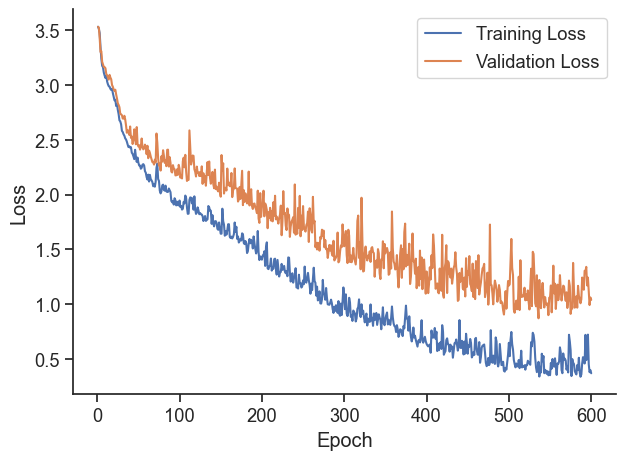

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,5))

sns.lineplot(x=range(1, num_epochs + 1), y=history['train_loss'], label='Training Loss', ax  = ax)
sns.lineplot(x=range(1, num_epochs + 1), y=history['val_loss'], label='Validation Loss', ax = ax)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
sns.despine()

We save the model by first gathering its parameters, then storing them in a file. There is also a helper function to load the model if needed later. MAKE SURE TO UPDLOAD THE MODEL TO GITHUB IF YOU WANT TO GET GRADED. You should upload the `trained_model.pth` file to "./assignment" folder in the repository. 

In [ ]:
def save_model(model, filepath):
    # Get model parameters
    model_params = {
        'input_size': model.input_size,
        'hidden_size': model.hidden_size,
        'output_size': model.output_size,
        'state_dict': model.state_dict()
    }

    # Save model parameters and state
    save(model_params, filepath)

def load_model(filepath):
    # Load model parameters and state
    model_params = load(filepath)

    # Create model with saved parameters
    model = CustomNeuralNetwork(
        input_size=model_params['input_size'],
        hidden_size=model_params['hidden_size'],
        output_size=model_params['output_size']
    )

    # Load the state dictionary
    model.load_state_dict(model_params['state_dict'])

    return model

# Save the trained model
save_model(model, 'trained_model.pth')

Next, we compute and compare the random baseline accuracy with our model’s accuracy on the test set. A higher score than random guessing suggests the RNN is learning patterns from user viewing sequences

In [ ]:
# Apply the model to the test set and compute the prediction accuracy
# Prepare test data
test_target = Tensor(test_data_table["target"].values).to(int64)
test_seqs = Tensor(test_data_table.drop(columns=["target"]).values).to(int64)
test_dataset = CustomDataset(vocab_size=vocab_size, sequences=test_seqs, target=test_target)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# First calculate random baseline accuracy
random_accuracy = 100 * 1.0 / vocab_size
print(f'Random Baseline Accuracy: {random_accuracy:.2f}%')

# Evaluate model on test set
model.eval()
correct = 0
total = 0

with no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        _, predicted = max(predictions, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch.squeeze()).sum().item()

test_accuracy = 100 * correct / total
print(f'Model Test Accuracy: {test_accuracy:.2f}%')

Random Baseline Accuracy: 2.94%
Model Test Accuracy: 72.40%
